$$\require{mhchem}$$
# Thermodynamics of the [Haber-Bosch process](https://en.wikipedia.org/wiki/Haber_process)

$\ce{\frac{1}{2}N2(g) + \frac{3}{2}H2(g) -> NH3(g)}$

(This is a solution to KFKA05's Exercise K17.3)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import R
from math import exp, sqrt
import scipy.integrate as integrate
from scipy.optimize import fsolve

In [2]:
# Heat capacity coefficients a, b, c
table = {
    "NH3": np.array([29.75, 25.10e-3, -1.55e5]),
    "N2": np.array([28.58, 3.77e-3, -0.5e5]),
    "H2": np.array([27.28, 3.26e-3, 0.5e5]),
}


def Cp(T):
    """heat capacity of reaction as a function of temperature (J/K/mol)"""
    a, b, c = table["NH3"] - 1 / 2 * table["N2"] - 3 / 2 * table["H2"]
    return a + b * T + c / T**2

## Equilibrium constant, $K(T)$
Here we calculate the equilibrium constant at different temperatures by numerically integrating
the heat capacity, $C_p(T)$, to obtain contributions from the enthalpy and entropy:
$$
\Delta H(T) = \Delta H(T_0) + \int_{T_0}^T C_p(T) dT
$$
and
$$
\Delta S(T) = \Delta S(T_0) + \int_{T_0}^T \frac{C_p(T)}{T} dT
$$
The reaction free energy is $\Delta G(T) = \Delta H(T) - T\Delta S(T)$ and the equilibrium constant,
$$
K(T) = e^{-\Delta G(T)/RT}
$$

In [3]:
def reaction_free_energy(T):
    """calculates the reaction free energy at a different temperature"""
    T0 = 298.15  # reference temperature
    dG0 = -16.48e3  # reference dG, J/mol
    dS0 = 192.45 - 1 / 2 * 191.61 - 3 / 2 * 130.684  # reference dS, J/mol
    dH0 = -46.11e3  # reference dH, J/mol
    dH = dH0 + integrate.quad(Cp, T0, T)[0]
    dS = dS0 + integrate.quad(lambda T: Cp(T) / T, T0, T)[0]
    dG = dH - T * dS
    return dG


for T in [298.15, 800, 900]:
    dG = reaction_free_energy(T)
    K = exp(-dG / R / T)
    print("dG({}) = {:.4} kJ/mol   K = {:.4}".format(T, dG / 1000, K))

dG(298.15) = -16.48 kJ/mol   K = 771.1
dG(800) = 38.78 kJ/mol   K = 0.002939
dG(900) = 50.47 kJ/mol   K = 0.001177


## Composition at elevated pressure and temperature

We now fix the temperature to 800 K and the pressure to $p$=80 bar.
What is the equilibrium composition if the mole-fraction of NH3 is 0.03 and with an excess of hydrogen?
$K$ is already known from the previous calculation.
The total pressure, $p=\sum_i p_i$ and $\sum_i x_i = 1$.
With $x_{H2}=1-x_{N2}-x_{NH3}$ we write

$$ K(800~K) = 0.002939 = \frac{\overbrace{x_{NH3}p}^{p_{NH3}}/p^{\circ}}{ (x_{N2}p/p^{\circ})^{1/2} \cdot (1-x_{N2}-x_{NH3})^{3/2} (p/p^{\circ})^{3/2}  } $$

and it's now only a matter of solving for $x_{N2}$.
Although this is in priciple easily done, Python's numerical schemes have trouble finding all roots in one go.
We will therefore need to start the solver with initial _guesses_ and as can be seen below, we obtain two roots.
As hydrogen is in _excess_, only the first found root is valid, and thus $x_{N2}$ = 0.0189.

In [4]:
K = 0.002939  # at 800 K (see above)
p = 80  # (bar divided by 1 bar, i.e. the standard state)
xNH3 = 0.03  # NH3 mole fraction

func = lambda xN2: xNH3 * p - K * (sqrt(xN2 * p) * ((1 - xN2 - xNH3) * p) ** (3 / 2))
fsolve(func, 0.0)[0], fsolve(func, 0.95)[0]

(0.0189242204053502, 0.6820767732127475)

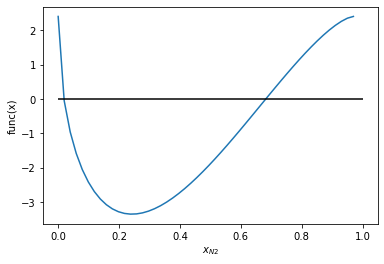

In [5]:
f = np.vectorize(func)
x = np.linspace(0, 0.97, 50)
plt.plot(x, f(x))
plt.xlabel("$x_{N2}$")
plt.ylabel("func(x)")
plt.hlines(0, 0, 1, color="black")